In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def load_image_gray(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [3]:
def compute_bm(left_gray, right_gray, num_disparities=16*6, block_size=15):
    num_disp = (num_disparities // 16) * 16
    bm = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)
    disp = bm.compute(left_gray, right_gray).astype(np.float32) / 16.0
    return disp

In [4]:
def compute_sgbm(left_gray, right_gray, num_disparities=16*6, block_size=3):
    num_disp = (num_disparities // 16) * 16
    P1 = 8 * block_size * block_size
    P2 = 32 * block_size * block_size
    sgbm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disp,
        blockSize=block_size,
        P1=P1,
        P2=P2,
        disp12MaxDiff=1,
        preFilterCap=63,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    disp = sgbm.compute(left_gray, right_gray).astype(np.float32) / 16.0
    return disp

In [5]:
def normalize_disparity_for_display(disp):
    disp_copy = disp.copy()
    disp_copy[disp_copy <= 0] = np.nan
    vmin = np.nanpercentile(disp_copy, 1) if np.isfinite(disp_copy).any() else 0
    vmax = np.nanpercentile(disp_copy, 99) if np.isfinite(disp_copy).any() else 1
    norm = (disp_copy - vmin) / (vmax - vmin + 1e-8)
    norm = np.clip(norm, 0, 1)
    disp_u8 = (255 * norm).astype(np.uint8)
    disp_color = cv2.applyColorMap(disp_u8, cv2.COLORMAP_JET)
    disp_color[np.isnan(disp_copy)] = (0, 0, 0)
    return disp_color

In [7]:
left_path = "/content/IMG.jpg"
right_path = "/content/images.jpg"

⚠️ Resizing right image to match left image size...


/tmp/ipython-input-2017643259.py:8: RuntimeWarning: invalid value encountered in cast
  disp_u8 = (255 * norm).astype(np.uint8)


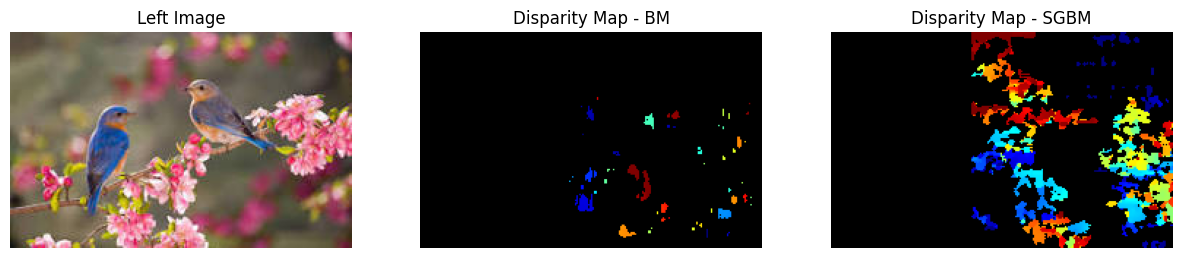

In [9]:
if os.path.exists(left_path) and os.path.exists(right_path):
    left_bgr, left_gray = load_image_gray(left_path)
    right_bgr, right_gray = load_image_gray(right_path)

    if left_gray.shape != right_gray.shape:
        print("⚠️ Resizing right image to match left image size...")
        right_bgr = cv2.resize(right_bgr, (left_gray.shape[1], left_gray.shape[0]))
        right_gray = cv2.cvtColor(right_bgr, cv2.COLOR_BGR2GRAY)

    disp_bm = compute_bm(left_gray, right_gray)
    disp_sgbm = compute_sgbm(left_gray, right_gray)

    disp_bm_color = normalize_disparity_for_display(disp_bm)
    disp_sgbm_color = normalize_disparity_for_display(disp_sgbm)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(left_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Left Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(disp_bm_color, cv2.COLOR_BGR2RGB))
    plt.title("Disparity Map - BM")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(disp_sgbm_color, cv2.COLOR_BGR2RGB))
    plt.title("Disparity Map - SGBM")
    plt.axis("off")

    plt.show()
else:
    print("Please update left_path and right_path with correct image file paths!")
